# ML Project: Donor Choose
### Team Members: Tiffany, Zihan, Anshika

## Importing Data Files

In [369]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

donations = pd.read_csv('donations.csv')
essays = pd.read_csv('essays.csv')
outcomes = pd.read_csv('outcomes.csv')
projects = pd.read_csv('projects.csv')
resources = pd.read_csv('resources.csv')

## if running from colab 
# from google.colab import drive
# drive.mount('/content/drive')
# donations = pd.read_csv('/content/drive/MyDrive/MLProject/dataset/donations.csv')
# essays = pd.read_csv('/content/drive/MyDrive/MLProject/dataset/essays.csv')
# outcomes = pd.read_csv('/content/drive/MyDrive/MLProject/dataset/outcomes.csv')
# projects = pd.read_csv('/content/drive/MyDrive/MLProject/dataset/projects.csv')
# resources = pd.read_csv('/content/drive/MyDrive/MLProject/dataset/resources.csv')


## Data Merging and Cleaning

In [370]:
# merge projects
df = projects.merge(outcomes[['projectid', 'fully_funded']], on='projectid', how='left')

# merge essays
df = df.merge(essays[['projectid', 'title', 'short_description', 'need_statement', 'essay']], on='projectid', how='left')

# Aggregate resources
resources_summary = resources.groupby('projectid').agg({
    'item_unit_price': ['sum', 'mean', 'max'],
    'item_quantity': ['sum', 'mean'],
    'project_resource_type': pd.Series.nunique
})
resources_summary.columns = [
    'resource_cost_sum', 'resource_price_avg', 'resource_price_max',
    'item_quantity_sum', 'item_quantity_avg', 'resource_type_count'
]
resources_summary = resources_summary.reset_index()
#merge resources
df = df.merge(resources_summary, on='projectid', how='left')

In [371]:
df.head()

,projectid,teacher_acctid,schoolid,school_ncesid,school_latitude,school_longitude,school_city,school_state,school_zip,school_metro,...,title,short_description,need_statement,essay,resource_cost_sum,resource_price_avg,resource_price_max,item_quantity_sum,item_quantity_avg,resource_type_count
0,316ed8fb3b81402ff6ac8f721bb31192,42d43fa6f37314365d08692e08680973,c0e6ce89b244764085691a1b8e28cb81,6.362701e+10,36.576340,-119.608713,Selma,CA,93662.0,NaN,...,Multiculturalism in Literacy,Can we read one more chapter? Do we have to go...,My students need 3 novel sets with multicultur...,Can we read one more chapter? Do we have to go...,14.40,4.80,5.10,99.0,33.00,1.0
1,90de744e368a7e4883223ca49318ae30,864eb466462bf704bf7a16a585ef296a,d711e47810900c96f26a5d0be30c446d,4.837020e+11,32.911179,-96.723640,Dallas,TX,75243.0,urban,...,Reading is the Window to the World!,Engaging reading materials sent right to my st...,My students need exciting reading materials li...,Engaging reading materials sent right to my st...,83.44,10.43,47.32,50.0,6.25,1.0
2,32943bb1063267de6ed19fc0ceb4b9a7,37f85135259ece793213aca9d8765542,665c3613013ba0a66e3a2a26b89f1b68,4.103270e+11,45.166039,-122.414576,Colton,OR,97017.0,rural,...,A Little Tech Goes A Long Way,Our second grade in rural Oregon is an adventu...,My students need an iPad Mini.,Our second grade in rural Oregon is an adventu...,379.99,379.99,379.99,1.0,1.00,1.0
3,bb18f409abda2f264d5acda8cab577a9,2133fc46f951f1e7d60645b0f9e48a6c,4f12c3fa0c1cce823c7ba1df57e90ccb,3.600153e+11,40.641727,-73.965655,Brooklyn,NY,11226.0,urban,...,"Provide Content Aligned, Leveled Texts, For Sc...",Help give 12 Brooklyn students access and orga...,My students need social studies literature res...,Help give 12 Brooklyn students access and orga...,538.00,269.00,329.00,2.0,1.00,1.0
4,24761b686e18e5eace634607acbcc19f,867ff478a63f5457eaf41049536c47cd,10179fd362d7b8cf0e89baa1ca3025bb,6.227100e+10,34.043939,-118.288371,Los Angeles,CA,90006.0,urban,...,Multi-Media Cart,Technology is changing the world as we speak. ...,My students need a multi-media workstation car...,Technology is changing the world as we speak. ...,341.98,170.99,278.99,2.0,1.00,1.0


# Feature Engineering

In [372]:
# aggregate donations
donations_agg = donations.groupby('projectid').agg({
    'donor_acctid': 'nunique',        
    'donationid': 'count'              
}).reset_index()

donations_agg = donations_agg.rename(columns={
    'donor_acctid': 'num_unique_donors',
    'donationid': 'donation_counts'
})

# Merge donations
df = df.merge(donations_agg, on='projectid', how='left')

# Drop columns with too many missing values
missing_pct = df.isnull().mean().sort_values(ascending=False)
cols_to_drop = missing_pct[missing_pct > 0.4].index
df = df.drop(columns=cols_to_drop)

# Drop rows with missing labels
df = df.dropna(subset=['fully_funded'])


# Fill other NaNs with median
df = df.fillna({
    'students_reached': df['students_reached'].median(),
    'total_price_including_optional_support': df['total_price_including_optional_support'].median()
})

# text features 
df['date_posted'] = pd.to_datetime(df['date_posted'], errors='coerce')
df['essay_length'] = df['essay'].astype(str).apply(len)
df['title_length'] = df['title'].astype(str).apply(len)
df['need_statement_length'] = df['need_statement'].astype(str).apply(len)
df['short_description_length'] = df['short_description'].astype(str).apply(len)

df['month_posted'] = df['date_posted'].dt.month
df['year_posted'] = df['date_posted'].dt.year
df['fully_funded_bin'] = df['fully_funded'].map({'t': 1, 'f': 0})

df = df[df['school_state'].isin(['NM','MI','UT','AZ','HI','CT','AA','WA','GA','OK','AE','CO','SC','TX'])]
df.to_csv('df.csv', index=False)
print(df.shape)
print(df.columns.tolist())
print(df['projectid'].is_unique)
df.columns.to_list()


(139377, 55)
['projectid', 'teacher_acctid', 'schoolid', 'school_ncesid', 'school_latitude', 'school_longitude', 'school_city', 'school_state', 'school_zip', 'school_metro', 'school_district', 'school_county', 'school_charter', 'school_magnet', 'school_year_round', 'school_nlns', 'school_kipp', 'school_charter_ready_promise', 'teacher_prefix', 'teacher_teach_for_america', 'teacher_ny_teaching_fellow', 'primary_focus_subject', 'primary_focus_area', 'secondary_focus_subject', 'secondary_focus_area', 'resource_type', 'poverty_level', 'grade_level', 'fulfillment_labor_materials', 'total_price_excluding_optional_support', 'total_price_including_optional_support', 'students_reached', 'eligible_double_your_impact_match', 'eligible_almost_home_match', 'date_posted', 'fully_funded', 'title', 'short_description', 'need_statement', 'essay', 'resource_cost_sum', 'resource_price_avg', 'resource_price_max', 'item_quantity_sum', 'item_quantity_avg', 'resource_type_count', 'num_unique_donors', 'donati

['projectid',
 'teacher_acctid',
 'schoolid',
 'school_ncesid',
 'school_latitude',
 'school_longitude',
 'school_city',
 'school_state',
 'school_zip',
 'school_metro',
 'school_district',
 'school_county',
 'school_charter',
 'school_magnet',
 'school_year_round',
 'school_nlns',
 'school_kipp',
 'school_charter_ready_promise',
 'teacher_prefix',
 'teacher_teach_for_america',
 'teacher_ny_teaching_fellow',
 'primary_focus_subject',
 'primary_focus_area',
 'secondary_focus_subject',
 'secondary_focus_area',
 'resource_type',
 'poverty_level',
 'grade_level',
 'fulfillment_labor_materials',
 'total_price_excluding_optional_support',
 'total_price_including_optional_support',
 'students_reached',
 'eligible_double_your_impact_match',
 'eligible_almost_home_match',
 'date_posted',
 'fully_funded',
 'title',
 'short_description',
 'need_statement',
 'essay',
 'resource_cost_sum',
 'resource_price_avg',
 'resource_price_max',
 'item_quantity_sum',
 'item_quantity_avg',
 'resource_type_coun

# EDA on Features (Correlation Analysis)

In [373]:
print("Number of projects:", df.shape[0])
print("Columns:", df.shape[1])
print(df['fully_funded'].value_counts(normalize=True))


Number of projects: 139377
Columns: 55
fully_funded
t    0.670541
f    0.329459
Name: proportion, dtype: float64


In [374]:
print("Poverty level")
print(df['poverty_level'].value_counts())

print("\nGrade level")
print(df['grade_level'].value_counts())

print("\nSubject")
print(df['primary_focus_area'].value_counts())

print("\nStates")
print(df['school_state'].value_counts().head(10))


Poverty level
poverty_level
highest poverty     72324
high poverty        42605
moderate poverty    21588
low poverty          2860
Name: count, dtype: int64

Grade level
grade_level
Grades PreK-2    53590
Grades 3-5       46081
Grades 6-8       21700
Grades 9-12      18004
Name: count, dtype: int64

Subject
primary_focus_area
Literacy & Language    62727
Math & Science         36835
Music & The Arts       12099
Applied Learning       10342
Special Needs           7991
History & Civics        5882
Health & Sports         3492
Name: count, dtype: int64

States
school_state
TX    37200
SC    17587
OK    14101
GA    13736
MI    11019
WA     9714
AZ     8942
UT     8703
CT     7146
CO     6475
Name: count, dtype: int64


# Visual Exploratory Data Analysis

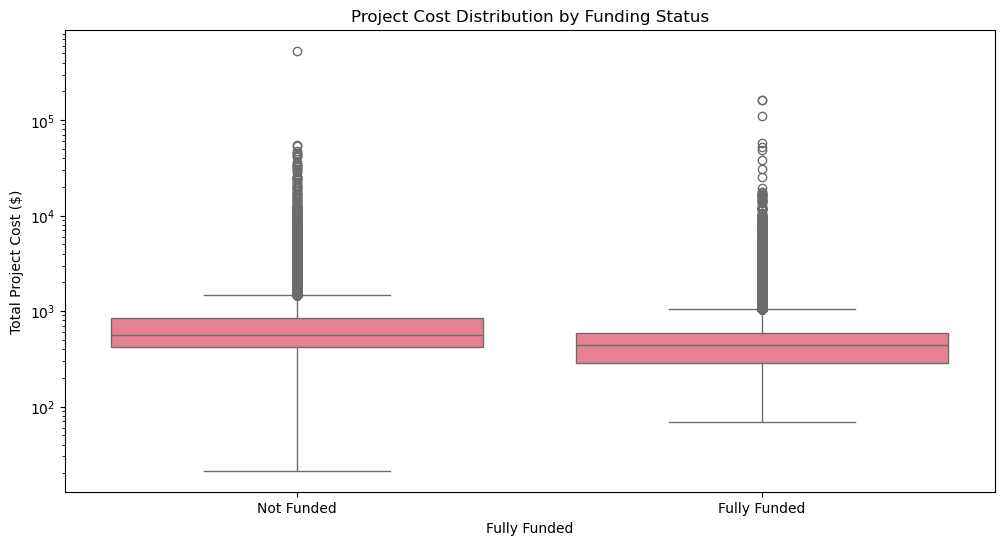

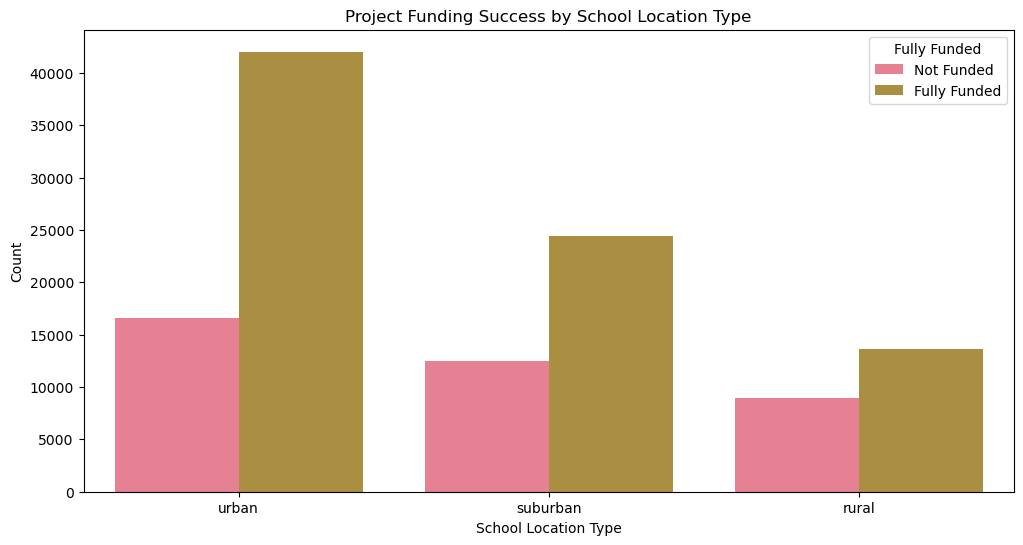

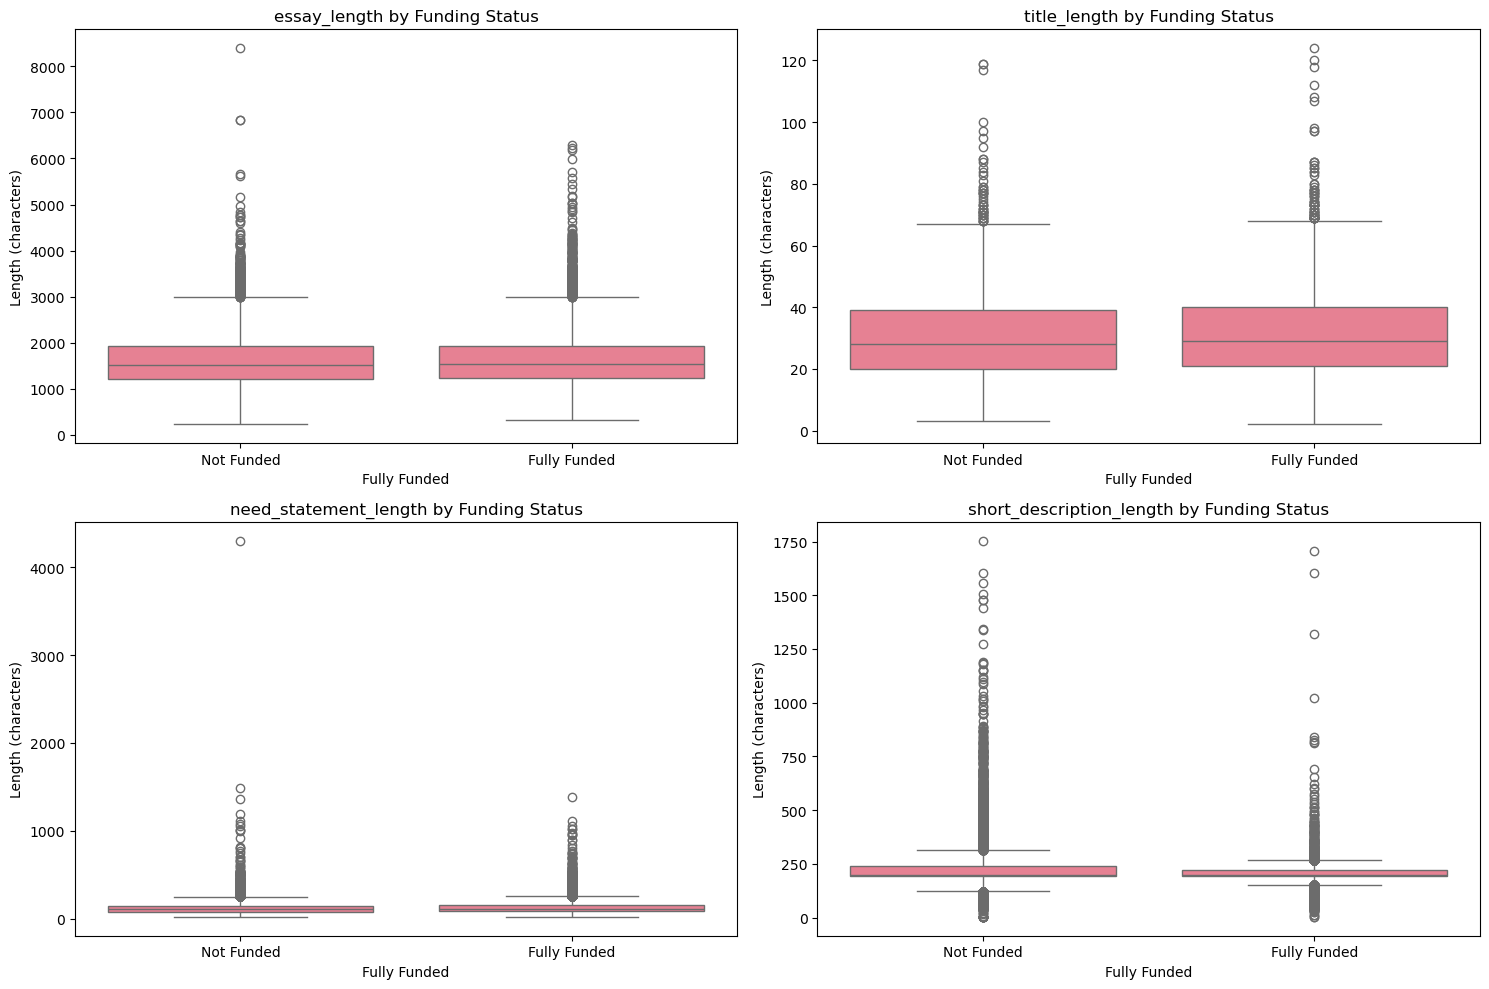

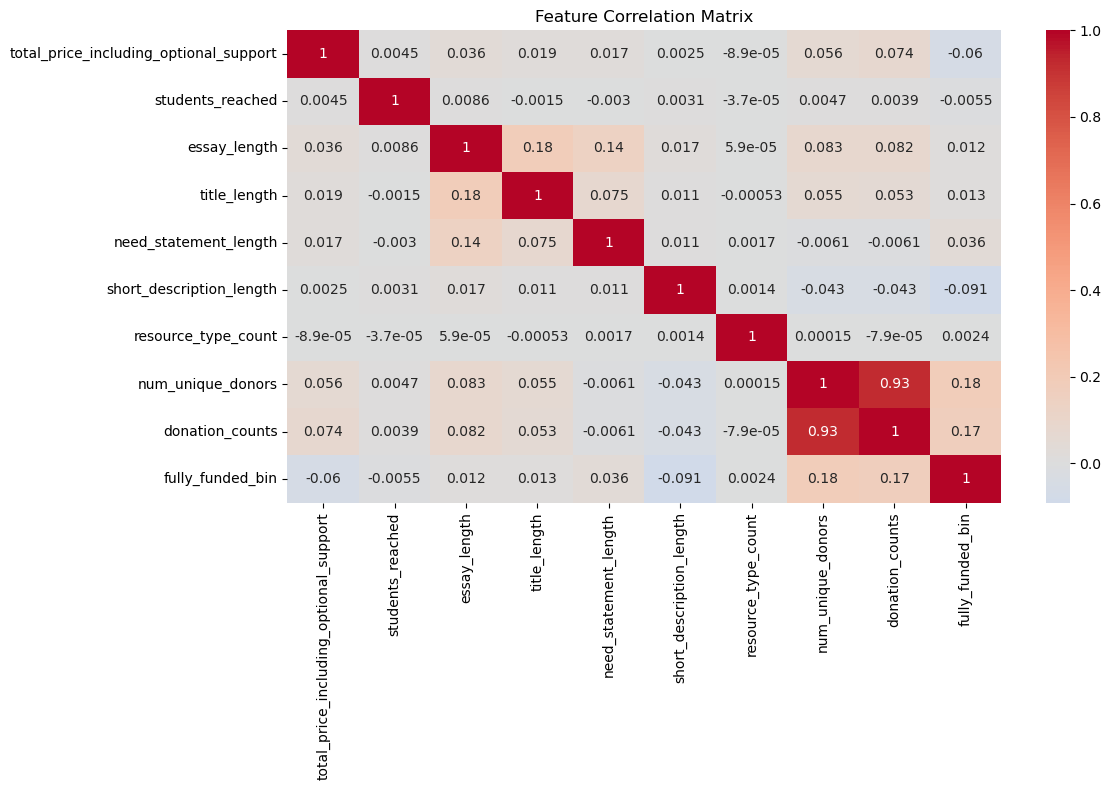

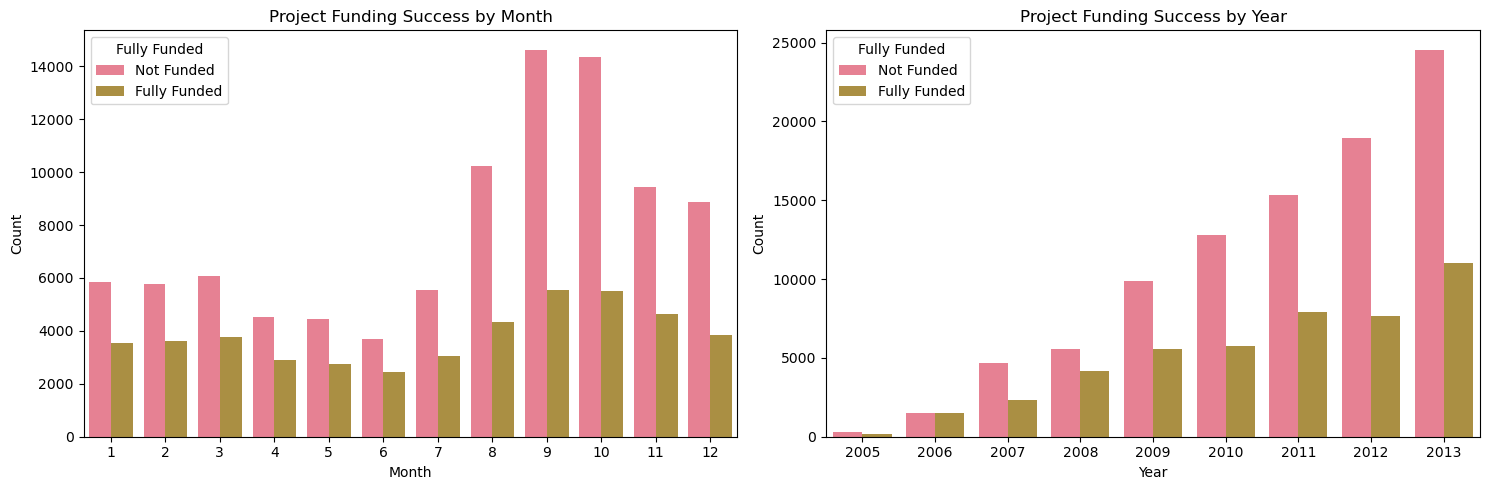

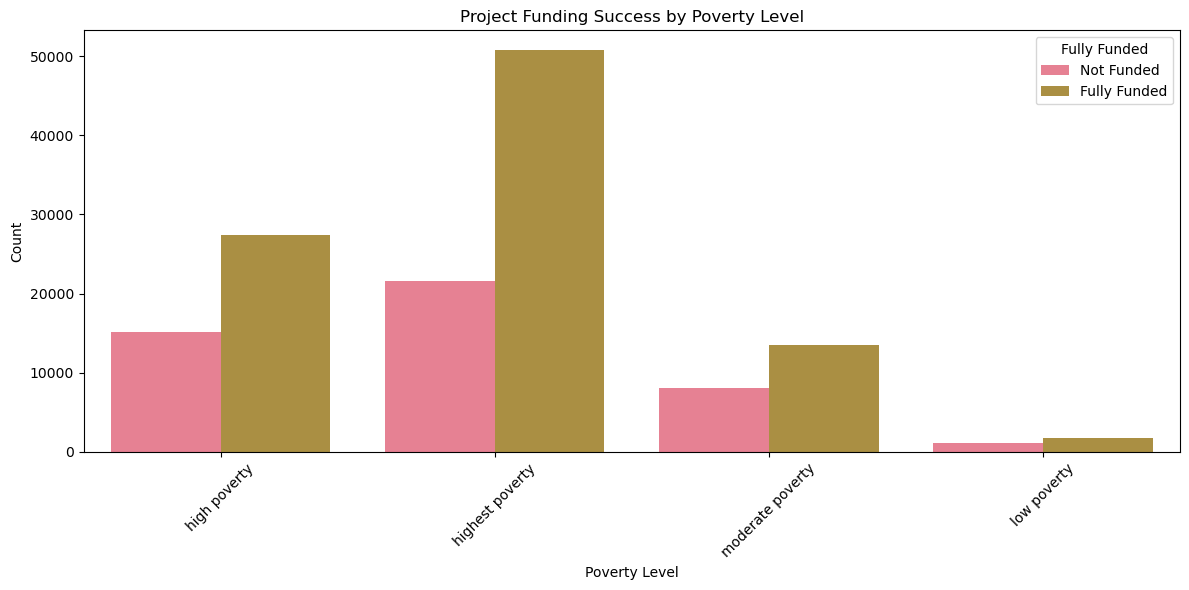

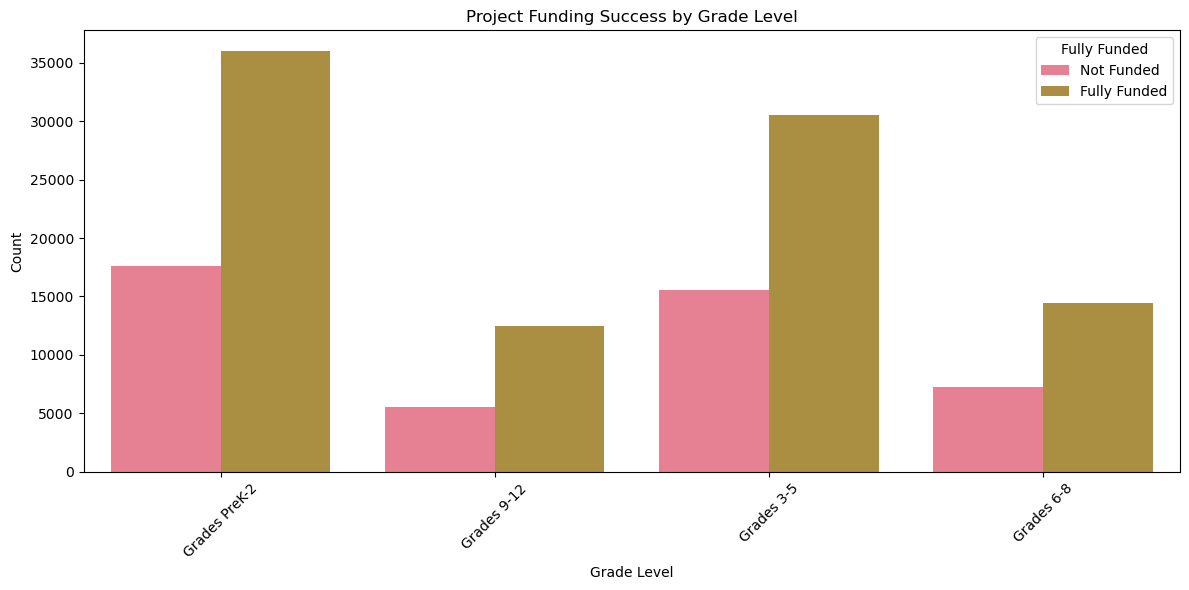

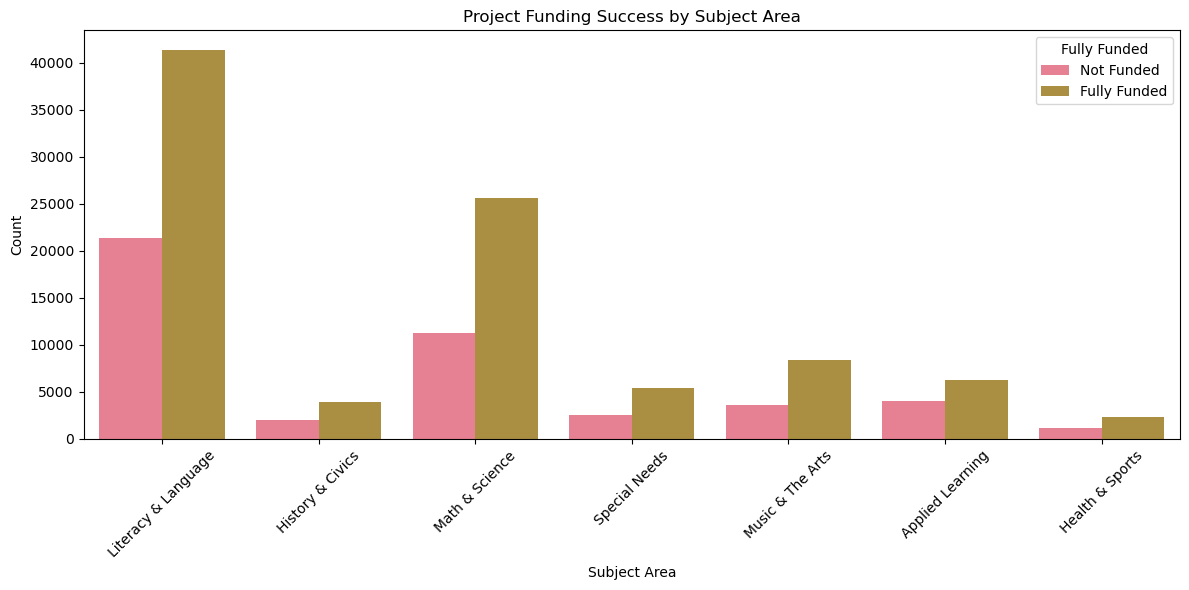

In [375]:
# ============ EDA: Feature Analysis ============

plt.style.use('default')
sns.set_palette("husl")

#  Project Cost Analysis
plt.figure(figsize=(12, 6))
sns.boxplot(x='fully_funded', y='total_price_including_optional_support', data=df)
plt.title('Project Cost Distribution by Funding Status')
plt.xlabel('Fully Funded')
plt.ylabel('Total Project Cost ($)')
plt.xticks([0, 1], ['Not Funded', 'Fully Funded'])
plt.yscale('log')
plt.show()

# School Location Impact
plt.figure(figsize=(12, 6))
sns.countplot(x='school_metro', hue='fully_funded', data=df)
plt.title('Project Funding Success by School Location Type')
plt.xlabel('School Location Type')
plt.ylabel('Count')
plt.legend(title='Fully Funded', labels=['Not Funded', 'Fully Funded'])
plt.show()

# Text Length Analysis
text_features = ['essay_length', 'title_length', 'need_statement_length', 'short_description_length']
plt.figure(figsize=(15, 10))
for i, feature in enumerate(text_features, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x='fully_funded', y=feature, data=df)
    plt.title(f'{feature} by Funding Status')
    plt.xlabel('Fully Funded')
    plt.ylabel('Length (characters)')
    plt.xticks([0, 1], ['Not Funded', 'Fully Funded'])
plt.tight_layout()
plt.show()


# Correlation Analysis
numeric_features = ['total_price_including_optional_support', 'students_reached', 
                   'essay_length', 'title_length', 'need_statement_length', 
                   'short_description_length', 'resource_type_count', 
                   'num_unique_donors', 'donation_counts']

correlation_matrix = df[numeric_features + ['fully_funded_bin']].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()


# Time-based Analysis
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.countplot(x='month_posted', hue='fully_funded', data=df)
plt.title('Project Funding Success by Month')
plt.xlabel('Month')
plt.ylabel('Count')
plt.legend(title='Fully Funded', labels=['Not Funded', 'Fully Funded'])

plt.subplot(1, 2, 2)
sns.countplot(x='year_posted', hue='fully_funded', data=df)
plt.title('Project Funding Success by Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend(title='Fully Funded', labels=['Not Funded', 'Fully Funded'])
plt.tight_layout()
plt.show()

# Poverty Level Analysis
plt.figure(figsize=(12, 6))
sns.countplot(x='poverty_level', hue='fully_funded', data=df)
plt.title('Project Funding Success by Poverty Level')
plt.xlabel('Poverty Level')
plt.ylabel('Count')
plt.legend(title='Fully Funded', labels=['Not Funded', 'Fully Funded'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Grade Level Analysis
plt.figure(figsize=(12, 6))
sns.countplot(x='grade_level', hue='fully_funded', data=df)
plt.title('Project Funding Success by Grade Level')
plt.xlabel('Grade Level')
plt.ylabel('Count')
plt.legend(title='Fully Funded', labels=['Not Funded', 'Fully Funded'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Subject Area Analysis
plt.figure(figsize=(12, 6))
sns.countplot(x='primary_focus_area', hue='fully_funded', data=df)
plt.title('Project Funding Success by Subject Area')
plt.xlabel('Subject Area')
plt.ylabel('Count')
plt.legend(title='Fully Funded', labels=['Not Funded', 'Fully Funded'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Cosine Similarity on TF-IDF vectors
### To find Correlation between columns: title, short_description, need_statement, essay

title vs short_description: 0.0186
title vs need_statement: 0.0171
title vs essay: 0.0602
short_description vs need_statement: 0.0237
short_description vs essay: 0.0578
need_statement vs essay: 0.0611
                      title  short_description  need_statement     essay
title              1.000000           0.017027        0.077823  0.188479
short_description  0.017027           1.000000        0.010214  0.018237
need_statement     0.077823           0.010214        1.000000  0.138283
essay              0.188479           0.018237        0.138283  1.000000


/var/folders/yt/r5wgtmb12n17g42ykp7839w00000gn/T/ipykernel_4073/795743391.py:38: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  text = sample_df[['title', 'short_description', 'need_statement', 'essay']].applymap(lambda x: len(str(x)))


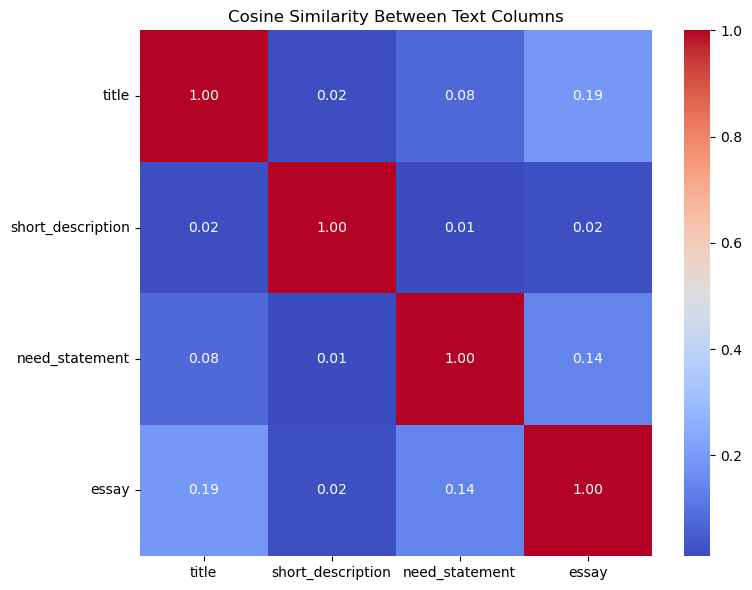

In [376]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

#To avoid the kernel from dying we are just sampling 15,000 rows to analyse our similarity

sample_df = df[['title', 'short_description', 'need_statement', 'essay']].fillna('').sample(15000, random_state=42)

# Create a TF-IDF Vectorizer
vectorizer = TfidfVectorizer(stop_words='english')

# Create a dictionary to hold similarity scores
similarity_results = {}

# Loop through each pair of columns
columns = sample_df.columns
for i in range(len(columns)):
    for j in range(i + 1, len(columns)):
        col1, col2 = columns[i], columns[j]
        
        # Combine the two columns' text
        combined_text = sample_df[col1] + " " + sample_df[col2]
        
        # Fit and transform TF-IDF
        tfidf_matrix = vectorizer.fit_transform(combined_text)
        
        # Compute average cosine similarity between col1 and col2
        sim_matrix = cosine_similarity(tfidf_matrix)
        avg_similarity = sim_matrix.mean()
        
        similarity_results[f"{col1} vs {col2}"] = avg_similarity

# Display results
for pair, score in similarity_results.items():
    print(f"{pair}: {score:.4f}")

#Finding Correlation

text = sample_df[['title', 'short_description', 'need_statement', 'essay']].applymap(lambda x: len(str(x)))
correl_matrix = text.corr()
print(correl_matrix)

#Plot heatmap

plt.figure(figsize=(8, 6))
sns.heatmap(correl_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Cosine Similarity Between Text Columns')
plt.tight_layout()
plt.show()

# Feature Selection

In [377]:

# features
all_feature_cols = [
    # These are the features we included for our model.
    'total_price_including_optional_support',
    'essay_length',
    'need_statement_length',
    'poverty_level',
    'students_reached',
    'month_posted',
    'school_state',
    'num_unique_donors',
    'year_posted',
    'eligible_double_your_impact_match',
    'eligible_almost_home_match',
    'grade_level',
    'resource_type',
    'secondary_focus_subject',
    'donation_counts'
]

# Drop rows with missing required values
df_model = df[all_feature_cols + ['fully_funded_bin']].dropna()

# Define X and y
X = df_model[all_feature_cols]
y = df_model['fully_funded_bin']

df_model.to_csv('feature_matrix.csv', index=False)

print(df_model.shape)
df_model.to_csv('feature_matrix.csv', index=False)
df_model


(79926, 16)


,total_price_including_optional_support,essay_length,need_statement_length,poverty_level,students_reached,month_posted,school_state,num_unique_donors,year_posted,eligible_double_your_impact_match,eligible_almost_home_match,grade_level,resource_type,secondary_focus_subject,donation_counts,fully_funded_bin
44777,809.54,1118,93,high poverty,22.0,12,SC,2.0,2013,f,f,Grades PreK-2,Supplies,Mathematics,2.0,0
44784,610.62,1047,50,highest poverty,160.0,12,NM,4.0,2013,f,f,Grades 9-12,Technology,History & Geography,4.0,1
44789,937.85,1951,166,high poverty,24.0,12,TX,10.0,2013,f,f,Grades PreK-2,Technology,Mathematics,15.0,1
44791,430.22,2362,86,highest poverty,19.0,12,CO,8.0,2013,f,f,Grades PreK-2,Technology,Early Development,8.0,1
44801,511.64,1784,126,moderate poverty,15.0,12,AZ,12.0,2013,f,f,Grades 6-8,Supplies,Mathematics,19.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
653144,1962.50,1305,276,moderate poverty,20.0,8,SC,1.0,2005,f,f,Grades PreK-2,Books,Literacy,1.0,0
653157,2148.76,1537,73,highest poverty,40.0,8,SC,1.0,2005,f,f,Grades 3-5,Technology,Applied Sciences,1.0,1
653195,436.59,1247,132,moderate poverty,225.0,8,SC,1.0,2005,f,f,Grades 6-8,Supplies,Environmental Science,1.0,1
653211,1352.50,1373,298,high poverty,400.0,8,SC,1.0,2005,f,f,Grades 6-8,Supplies,Character Education,1.0,1


# Models Imports

In [378]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import lightgbm as lgb # type: ignore

# Encoding and Train/Test split

In [379]:
# One hot encode categorical variables
X_encoded = pd.get_dummies(X, columns=['resource_type', 'poverty_level', 'school_state', 'eligible_double_your_impact_match', 'eligible_almost_home_match', 'grade_level', 'secondary_focus_subject'], drop_first=True)

from sklearn.preprocessing import StandardScaler
# Scale numeric features
numeric_cols = [
    'total_price_including_optional_support',
    'essay_length',
    'need_statement_length',
    'students_reached',
    'month_posted',
    'num_unique_donors',
    'year_posted'
]
scaler = StandardScaler()
X_encoded[numeric_cols] = scaler.fit_transform(X_encoded[numeric_cols])



In [380]:
# split the data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

In [381]:
print("Feature matrix shape:", X_encoded.shape)
print("distribution:\n", y.value_counts(normalize=True))

Feature matrix shape: (79926, 58)
distribution:
 fully_funded_bin
1    0.803331
0    0.196669
Name: proportion, dtype: float64


# Model Training

In [382]:
# ==================== MODELS ====================
lr = LogisticRegression(max_iter=1000).fit(X_train, y_train)
rf = RandomForestClassifier(n_estimators=100, random_state=42).fit(X_train, y_train)
gb = GradientBoostingClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42).fit(X_train, y_train)
sgd = SGDClassifier(loss='log_loss', max_iter=1000, random_state=42).fit(X_train, y_train)
knn = KNeighborsClassifier(n_neighbors=5).fit(X_train, y_train)
xg =  xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder= False, random_state= 42,n_estimators=100, max_depth=6, learning_rate=0.1, scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(), ).fit(X_train, y_train)
lg = lgb.LGBMClassifier(objective='binary', boosting_type='gbdt', metric='recall', random_state= 42, n_estimators=100, learning_rate=0.1, max_depth=-1, class_weight='balanced').fit(X_train, y_train)

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:26:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 51365, number of negative: 12575
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001271 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1323
[LightGBM] [Info] Number of data points in the train set: 63940, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


# Feature Importance Analysis

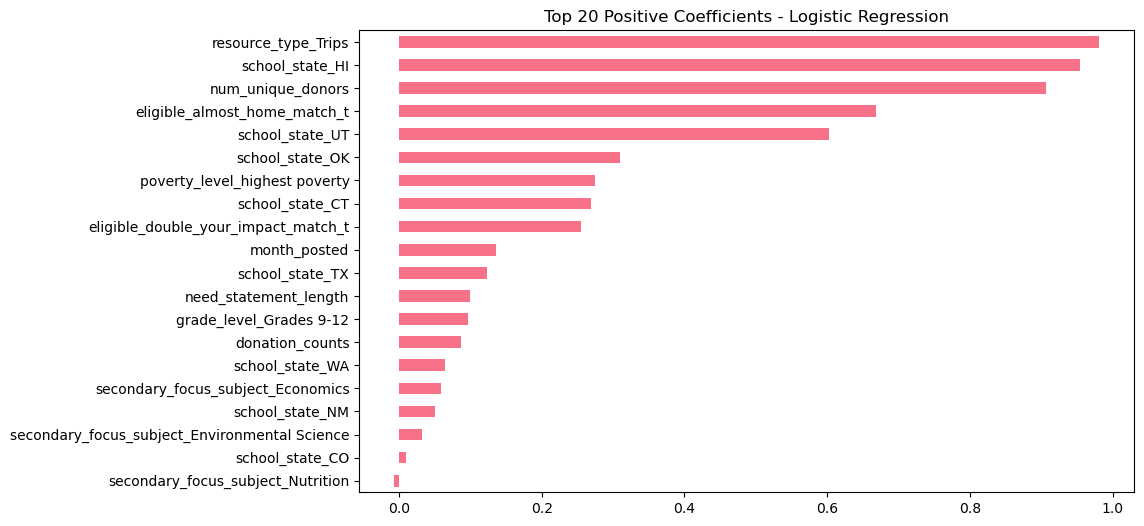

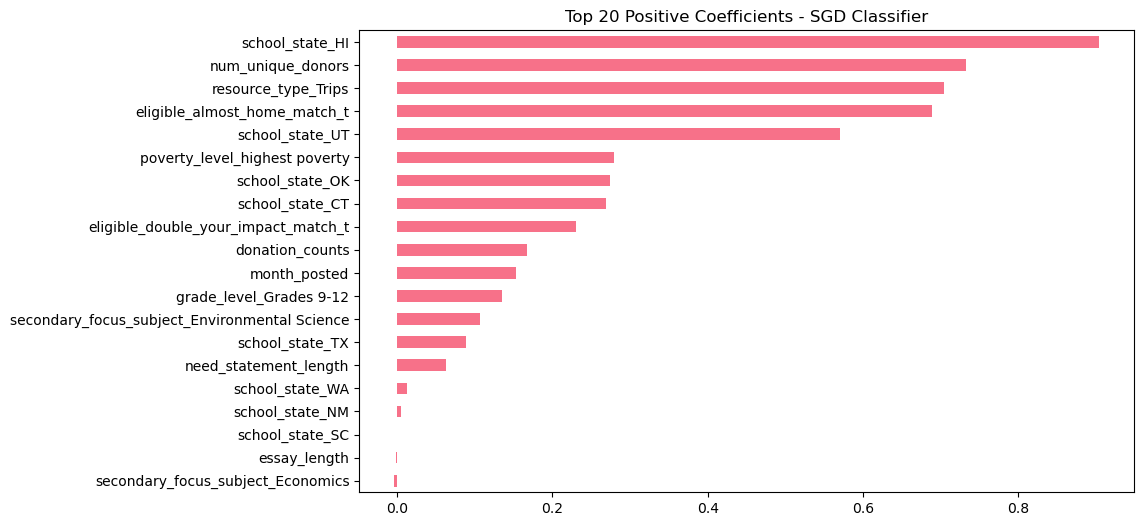

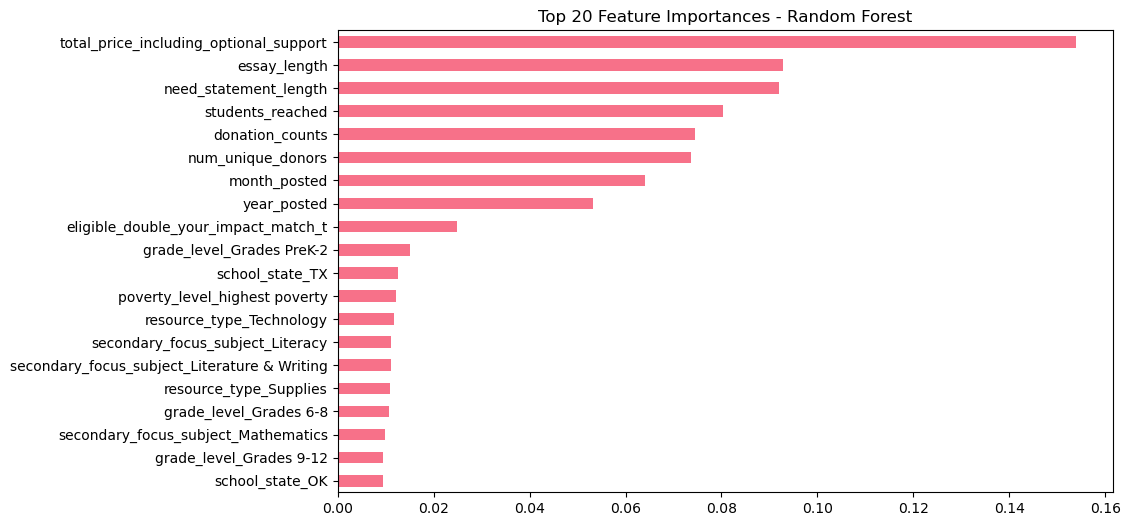

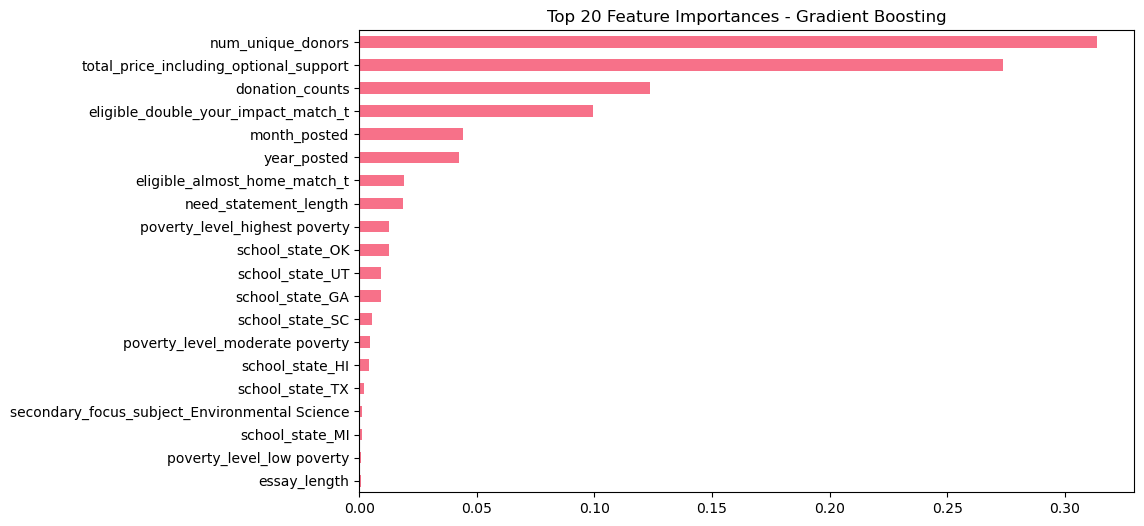

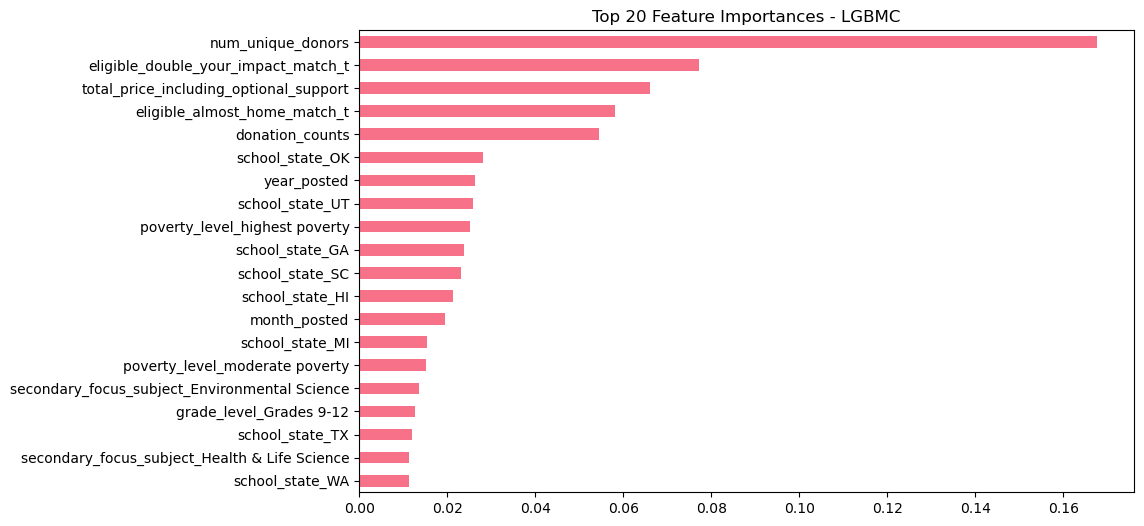

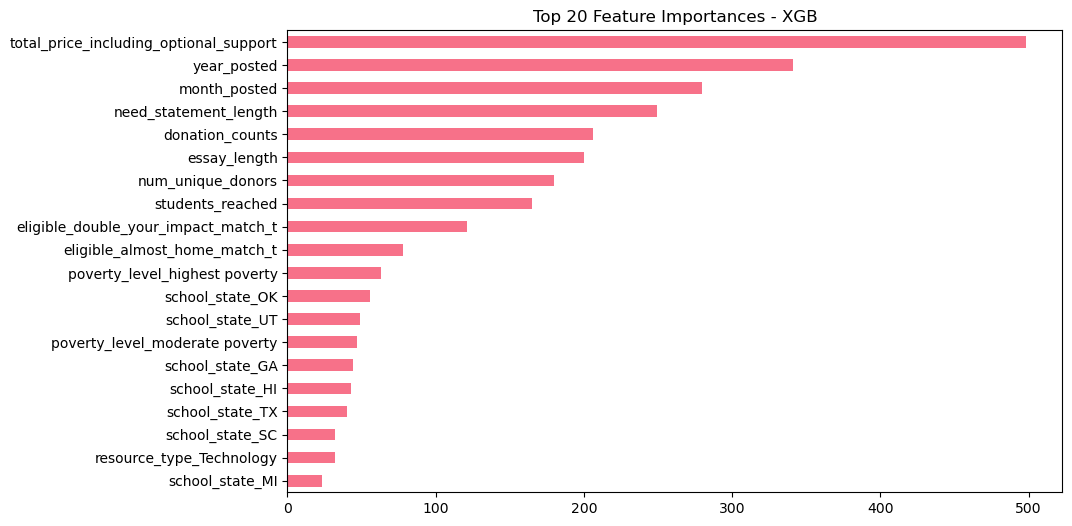

In [383]:
# ==================== FEATURE IMPORTANCE ====================
# Logistic Regression
lr_importance = pd.DataFrame(lr.coef_[0], index=X_encoded.columns, columns=['importance']).sort_values(by='importance')
lr_importance.tail(20).plot(kind='barh', figsize=(10, 6), legend=False)
plt.title("Top 20 Positive Coefficients - Logistic Regression")
plt.show()

# SGD
sgd_importance = pd.DataFrame(sgd.coef_[0], index=X_encoded.columns, columns=['importance']).sort_values(by='importance')
sgd_importance.tail(20).plot(kind='barh', figsize=(10, 6), legend=False)
plt.title("Top 20 Positive Coefficients - SGD Classifier")
plt.show()

# Random Forest
rf_importance = pd.DataFrame(rf.feature_importances_, index=X_encoded.columns, columns=['importance']).sort_values(by='importance')
rf_importance.tail(20).plot(kind='barh', figsize=(10, 6), legend=False)
plt.title("Top 20 Feature Importances - Random Forest")
plt.show()

# Gradient Boosting
gb_importance = pd.DataFrame(gb.feature_importances_, index=X_encoded.columns, columns=['importance']).sort_values(by='importance')
gb_importance.tail(20).plot(kind='barh', figsize=(10, 6), legend=False)
plt.title("Top 20 Feature Importances - Gradient Boosting")
plt.show()

# XGBoosting
xg_importance = pd.DataFrame(xg.feature_importances_, index=X_encoded.columns, columns=['importance']).sort_values(by='importance')
xg_importance.tail(20).plot(kind='barh', figsize=(10, 6), legend=False)
plt.title("Top 20 Feature Importances - LGBMC")
plt.show()

#Light Gradient Boosting Machine
lg_importance = pd.DataFrame(lg.feature_importances_, index=X_encoded.columns, columns=['importance']).sort_values(by='importance')
lg_importance.tail(20).plot(kind='barh', figsize=(10, 6), legend=False)
plt.title("Top 20 Feature Importances - XGB")
plt.show()


# Feature Importance Highlights

### 1. Logistic Regression
- **Most positively associated with success:**
  - `school_state_HI`, `school_state_NH`, `school_state_DC`
  - `poverty_level_highest poverty`
- Strong presence of **school_state** dummy variables shows that **geographic location** has high predictive power in linear separation.
- Also, `need_statement_length` appears to be relevant.

---

### 2. SGD Classifier
- Similar to Logistic Regression, but with **`resource_cost_sum`** as the top coefficient.
- High variance in coefficients (e.g., 1.2 for resource cost), possibly due to **regularization differences**.
- **State features** and `need_statement_length` are again **prominent**.

---

### 3. Random Forest
- **Top features:**
  - `total_price_including_optional_support`
  - `resource_cost_sum`
  - `essay_length`, `need_statement_length`, `students_reached`
- Tree-based models focus more on **numeric and continuous features**.
- **School states** and **poverty level dummies** rank lower — likely due to less consistent impact across decision splits.

---

### 4. Gradient Boosting
- **Dominated by**: `total_price_including_optional_support` (massively high importance)
- Next most important:
  - `need_statement_length`
  - `poverty_level_highest poverty`
  - A few `school_state` variables
- Suggests that **cost** and **poverty severity** are especially powerful when boosting decision trees.

---

### 5. XGBoosting
- **Dominated by**: `total_price_including_optional_support` (massively high importance)
- Next most important:
  - `year_posted`
  - `month_posted`
  - A few `school_state` variables
- Suggests that the model highly relies on cost and temporal data.

---

### 6. Light Gradient Boosting Machine Classifier (LGBMC)
- **Dominated by**: `num_unique_donors` (massively high importance)
- Next most important:
  - `eligible_double_your_impact`
  - `total_price_including_optional_support`
  - A few `school_state` variables
- Suggests that the model heavily relies on historical donation patterns and eligibility for funding matches.


## Model Evaluation

In [384]:
# ==================== EVALUATION ====================
y_probs = {
    'Logistic Regression': lr.predict_proba(X_test)[:, 1],
    'Random Forest': rf.predict_proba(X_test)[:, 1],
    'Gradient Boosting': gb.predict_proba(X_test)[:, 1],
    'SGD Classifier': sgd.predict_proba(X_test)[:, 1],
    'KNN': knn.predict_proba(X_test)[:, 1],
    'XGBoosting': xg.predict_proba(X_test)[:, 1],
    'LGBMC': lg.predict_proba(X_test)[:, 1]
}

results = pd.DataFrame({
    'Model': list(y_probs.keys()),
    'ROC AUC': [roc_auc_score(y_test, prob) for prob in y_probs.values()]
})
print(results)

from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

for model_name, y_prob in y_probs.items():
    y_pred = (y_prob >= 0.5).astype(int)
    print(f"\n{model_name} Classification Report (focus on not-funded projects):")
    print(classification_report(y_test, y_pred, target_names=['Not Funded', 'Funded']))

    precision = precision_score(y_test, y_pred, pos_label=0)
    recall = recall_score(y_test, y_pred, pos_label=0)
    f1 = f1_score(y_test, y_pred, pos_label=0)

    print(f"Precision (Not Funded): {precision:.3f}")
    print(f"Recall (Not Funded): {recall:.3f}")
    print(f"F1 Score (Not Funded): {f1:.3f}")



                 Model   ROC AUC
0  Logistic Regression  0.762210
1        Random Forest  0.850767
2    Gradient Boosting  0.834356
3       SGD Classifier  0.759344
4                  KNN  0.719516
5           XGBoosting  0.854600
6                LGBMC  0.853890

Logistic Regression Classification Report (focus on not-funded projects):
              precision    recall  f1-score   support

  Not Funded       0.53      0.08      0.13      3144
      Funded       0.81      0.98      0.89     12842

    accuracy                           0.80     15986
   macro avg       0.67      0.53      0.51     15986
weighted avg       0.76      0.80      0.74     15986

Precision (Not Funded): 0.525
Recall (Not Funded): 0.077
F1 Score (Not Funded): 0.134

Random Forest Classification Report (focus on not-funded projects):
              precision    recall  f1-score   support

  Not Funded       0.73      0.31      0.44      3144
      Funded       0.85      0.97      0.91     12842

    accuracy   

## ROC Curve Analysis of Our Models

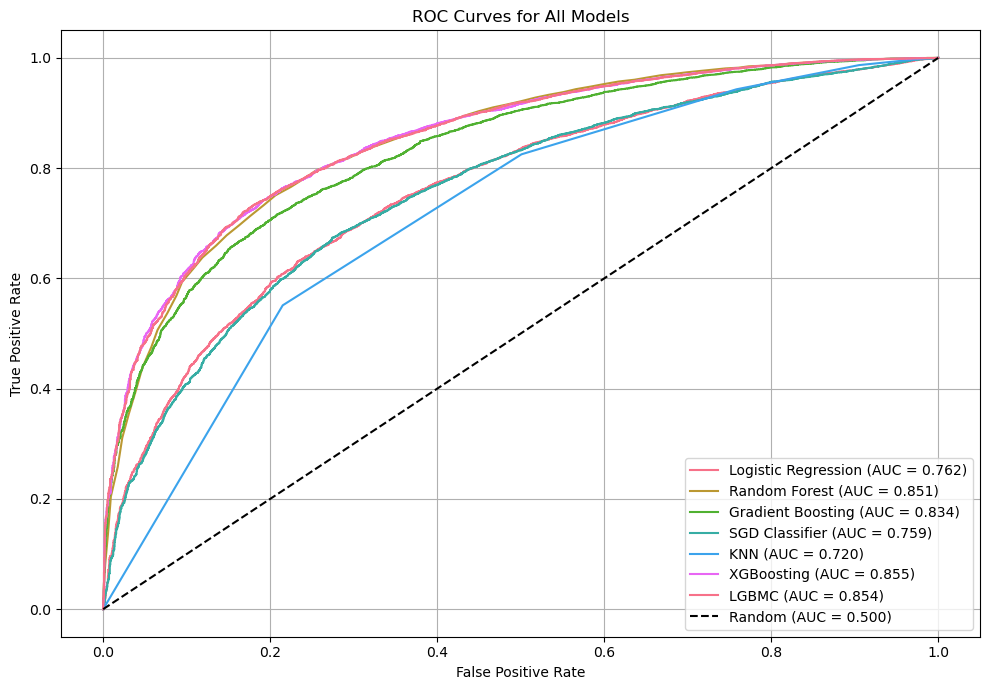

In [385]:
from sklearn.metrics import roc_curve

plt.figure(figsize=(10, 7))

for model_name, y_prob in y_probs.items():
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc_score = roc_auc_score(y_test, y_prob)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.3f})')

# Random baseline
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.500)')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


# Final Results of Models Performance

In [386]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

# Get predicted labels (using default threshold = 0.5)
y_preds = {
    'Logistic Regression': lr.predict(X_test),
    'Random Forest': rf.predict(X_test),
    'Gradient Boosting': gb.predict(X_test),
    'SGD Classifier': sgd.predict(X_test),
    'KNN': knn.predict(X_test),
    'XGBoosting': xg.predict(X_test),
    'LGBMC': lg.predict(X_test)
}

metrics = []

for model_name, y_pred in y_preds.items():
    precision = precision_score(y_test, y_pred, pos_label=0)
    recall = recall_score(y_test, y_pred, pos_label=0)
    f1 = f1_score(y_test, y_pred, pos_label=0)
    metrics.append({
        'Model': model_name,
        'Precision': precision,
        'Recall': recall,
        'F1-score': f1,
        'AUC': roc_auc_score(y_test, y_probs[model_name])
    })

metrics_df = pd.DataFrame(metrics)
print(metrics_df.sort_values(by='Recall', ascending=False))

                 Model  Precision    Recall  F1-score       AUC
5           XGBoosting   0.438351  0.798346  0.565953  0.854600
6                LGBMC   0.443811  0.792621  0.569015  0.853890
1        Random Forest   0.721300  0.331743  0.454466  0.850767
2    Gradient Boosting   0.675432  0.285941  0.401788  0.834356
4                  KNN   0.509383  0.241730  0.327869  0.719516
3       SGD Classifier   0.526957  0.096374  0.162947  0.759344
0  Logistic Regression   0.525054  0.076654  0.133777  0.762210


# We saw that the LGMC and XGBoosting model has been performing the best with the hyperparameter tunings and precise feature selections

## Identifying the bottom 10% of at risk unfunded project

In [387]:
# Get predicted probability of being funded (1 = funded)
full_probs = xg.predict_proba(X_encoded)[:, 1]

# Attach predictions to your original model dataframe
df_model['predicted_prob'] = full_probs
df_model['projectid'] = df.loc[df_model.index, 'projectid']  # attach project ID back

# Sort by lowest predicted probability (least likely to be funded)
df_ranked = df_model.sort_values(by='predicted_prob', ascending=True)

# Select bottom 10%
cutoff = int(len(df_ranked) * 0.10)
bottom_10 = df_ranked.head(cutoff)


bottom_10[['projectid', 'predicted_prob']].to_csv('projects_for_expert_review.csv', index=False)
print(bottom_10[['projectid', 'predicted_prob']].head(10))

                               projectid  predicted_prob
625211  fdd1681e70439299bf33a79cb92c7de4        0.020547
623775  07d1bf67ab06419edaff76efad0a9c14        0.023251
577980  5eb712eab9abb359e9b087ded2c6e933        0.024916
571908  8dbe7adfa4e7ca49fde988f6ced4dbce        0.025704
617469  abedf832b799c69d643dad2391d78d85        0.026690
622931  e7cd07109bc470b96a5656c964345aac        0.027417
618646  9c529ea393950448c26f35db03df78c5        0.027625
379935  6ed5f3dbaf9494907d87953e96f4573a        0.027712
621753  88e08beee947b02e44e0f56ea259f60e        0.028589
347424  1632b671fb8a72de5a1893341449dcca        0.028690


---

# Bias Audit for our LGBMC Model
### We conducted a bias audit by evaluating our model’s performance across different subgroups of poverty_level, grade_level, and school_state. For each group, we measured precision, recall, and F1 score for the Not Funded class using the test set. This helped us identify disparities

In [388]:
# Add test set columns to a new DataFrame
audit_df = X_test.copy()
audit_df['y_true'] = y_test.values
audit_df['y_pred'] = (lg.predict_proba(X_test)[:, 1] >= 0.5).astype(int)
audit_df['y_prob'] = lg.predict_proba(X_test)[:, 1]

# Join sensitive attributes back from original df
audit_df['poverty_level'] = df.loc[audit_df.index, 'poverty_level']
audit_df['grade_level'] = df.loc[audit_df.index, 'grade_level']
audit_df['school_state'] = df.loc[audit_df.index, 'school_state']

# Now audit across multiple features
sensitive_features = ['poverty_level', 'grade_level', 'school_state']
results = []

for feature in sensitive_features:
    for group in audit_df[feature].dropna().unique():
        group_df = audit_df[audit_df[feature] == group]
        if len(group_df) < 30:  # skip small groups to avoid unstable metrics
            continue

        precision = precision_score(group_df['y_true'], group_df['y_pred'], pos_label=0)
        recall = recall_score(group_df['y_true'], group_df['y_pred'], pos_label=0)
        f1 = f1_score(group_df['y_true'], group_df['y_pred'], pos_label=0)

        results.append({
            'Feature': feature,
            'Group': group,
            'Count': len(group_df),
            'Precision (Not Funded)': round(precision, 3),
            'Recall (Not Funded)': round(recall, 3),
            'F1 (Not Funded)': round(f1, 3)
        })

bias_audit_df = pd.DataFrame(results)
bias_audit_df


,Feature,Group,Count,Precision (Not Funded),Recall (Not Funded),F1 (Not Funded)
0,poverty_level,high poverty,4808,0.471,0.801,0.593
1,poverty_level,low poverty,333,0.452,0.807,0.580
2,poverty_level,moderate poverty,2410,0.428,0.820,0.562
3,poverty_level,highest poverty,8435,0.430,0.775,0.553
4,grade_level,Grades 6-8,2414,0.465,0.785,0.584
5,grade_level,Grades 9-12,1894,0.429,0.801,0.559
6,grade_level,Grades 3-5,5530,0.444,0.797,0.571
7,grade_level,Grades PreK-2,6148,0.439,0.789,0.564
8,school_state,WA,1224,0.452,0.748,0.564
9,school_state,TX,4212,0.406,0.785,0.536


### Some insights from our Bias Audit:
**From poverty level: Model is better at predicting underfunding in low-poverty schools.**

**From grade_level, there is no major disparities.**

**Our model performs unevenly by state. Projects in OK, NM, and HI are more likely to be misclassified as not funded — which could unfairly deprioritize them.**

# SMOTE analysis to see if the performance improves

In [389]:
# ============ SMOTE ============
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts().to_dict())
print("After SMOTE :", pd.Series(y_train_balanced).value_counts().to_dict())

Before SMOTE: {1: 51365, 0: 12575}
After SMOTE : {1: 51365, 0: 51365}


## Model Training

In [390]:
# ==================== MODELS ====================
lr = LogisticRegression(max_iter=1000).fit(X_train_balanced, y_train_balanced)
rf = RandomForestClassifier(n_estimators=100, random_state=42).fit(X_train_balanced, y_train_balanced)
gb = GradientBoostingClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42).fit(X_train_balanced, y_train_balanced)
sgd = SGDClassifier(loss='log_loss', max_iter=1000, random_state=42).fit(X_train_balanced, y_train_balanced)
knn = KNeighborsClassifier(n_neighbors=5).fit(X_train_balanced, y_train_balanced)
xg =  xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder= False, random_state= 42,n_estimators=100, max_depth=6, learning_rate=0.1, scale_pos_weight=(y_train_balanced == 0).sum() / (y_train_balanced == 1).sum(), ).fit(X_train_balanced, y_train_balanced)
lg = lgb.LGBMClassifier(objective='binary', boosting_type='gbdt', metric='recall', random_state= 42, n_estimators=100, learning_rate=0.1, max_depth=-1, class_weight='balanced').fit(X_train_balanced, y_train_balanced)

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:27:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 51365, number of negative: 51365
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006780 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2140
[LightGBM] [Info] Number of data points in the train set: 102730, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


## Model Evaluation

In [391]:
# ==================== EVALUATION ====================
y_probs = {
    'Logistic Regression': lr.predict_proba(X_test)[:, 1],
    'Random Forest': rf.predict_proba(X_test)[:, 1],
    'Gradient Boosting': gb.predict_proba(X_test)[:, 1],
    'SGD Classifier': sgd.predict_proba(X_test)[:, 1],
    'KNN': knn.predict_proba(X_test)[:, 1],
    'XGBoosting': xg.predict_proba(X_test)[:, 1],
    'LGBMC': lg.predict_proba(X_test)[:, 1]
}

results = pd.DataFrame({
    'Model': list(y_probs.keys()),
    'ROC AUC': [roc_auc_score(y_test, prob) for prob in y_probs.values()]
})
print(results)

from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

for model_name, y_prob in y_probs.items():
    y_pred = (y_prob >= 0.5).astype(int)
    print(f"\n{model_name} Classification Report (focus on not-funded projects):")
    print(classification_report(y_test, y_pred, target_names=['Not Funded', 'Funded']))

    precision = precision_score(y_test, y_pred, pos_label=0)
    recall = recall_score(y_test, y_pred, pos_label=0)
    f1 = f1_score(y_test, y_pred, pos_label=0)

    print(f"Precision (Not Funded): {precision:.3f}")
    print(f"Recall (Not Funded): {recall:.3f}")
    print(f"F1 Score (Not Funded): {f1:.3f}")



                 Model   ROC AUC
0  Logistic Regression  0.717437
1        Random Forest  0.847360
2    Gradient Boosting  0.816866
3       SGD Classifier  0.717603
4                  KNN  0.720517
5           XGBoosting  0.842584
6                LGBMC  0.846871

Logistic Regression Classification Report (focus on not-funded projects):
              precision    recall  f1-score   support

  Not Funded       0.38      0.48      0.42      3144
      Funded       0.86      0.81      0.84     12842

    accuracy                           0.74     15986
   macro avg       0.62      0.64      0.63     15986
weighted avg       0.77      0.74      0.76     15986

Precision (Not Funded): 0.381
Recall (Not Funded): 0.476
F1 Score (Not Funded): 0.423

Random Forest Classification Report (focus on not-funded projects):
              precision    recall  f1-score   support

  Not Funded       0.60      0.50      0.55      3144
      Funded       0.88      0.92      0.90     12842

    accuracy   

## ROC Analysis

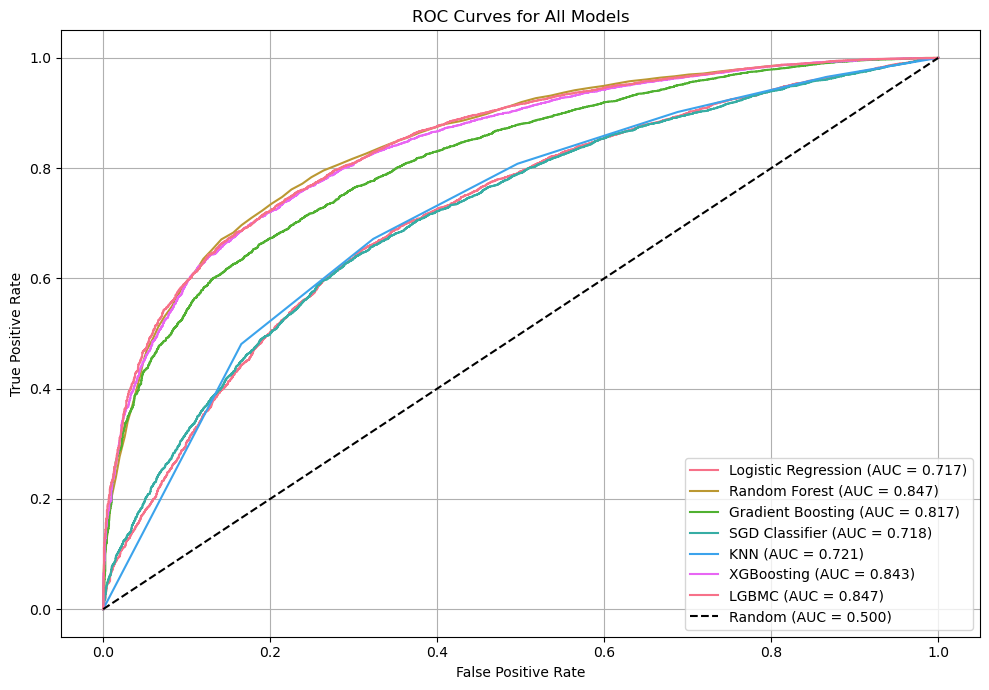

In [392]:
from sklearn.metrics import roc_curve

plt.figure(figsize=(10, 7))

for model_name, y_prob in y_probs.items():
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc_score = roc_auc_score(y_test, y_prob)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.3f})')

# Random baseline
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.500)')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

## Final Results of Models Performance with SMOTE

In [393]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

# Get predicted labels (using default threshold = 0.5)
y_preds = {
    'Logistic Regression': lr.predict(X_test),
    'Random Forest': rf.predict(X_test),
    'Gradient Boosting': gb.predict(X_test),
    'SGD Classifier': sgd.predict(X_test),
    'KNN': knn.predict(X_test),
    'XGBoosting': xg.predict(X_test),
    'LGBMC': lg.predict(X_test)
}

metrics = []

for model_name, y_pred in y_preds.items():
    precision = precision_score(y_test, y_pred, pos_label=0)
    recall = recall_score(y_test, y_pred, pos_label=0)
    f1 = f1_score(y_test, y_pred, pos_label=0)
    metrics.append({
        'Model': model_name,
        'Precision': precision,
        'Recall': recall,
        'F1-score': f1,
        'AUC': roc_auc_score(y_test, y_probs[model_name])
    })

metrics_df = pd.DataFrame(metrics)
print(metrics_df.sort_values(by='Recall', ascending=False))

                 Model  Precision    Recall  F1-score       AUC
2    Gradient Boosting   0.457049  0.617684  0.525362  0.816866
3       SGD Classifier   0.352798  0.553435  0.430906  0.717603
5           XGBoosting   0.556860  0.527990  0.542041  0.842584
1        Random Forest   0.589678  0.512405  0.548332  0.847360
4                  KNN   0.391111  0.503817  0.440367  0.720517
0  Logistic Regression   0.381110  0.476145  0.423360  0.717437
6                LGBMC   0.606571  0.469784  0.529486  0.846871


### **With SMOTE our model performance degraded in terms of Recall. We have decent precison now but that is not our primary evaluation matrix. ***

# **Finally, we have decided to go with SMOTE sampling technique. The model that we selected as the best performing model is the LGBMC model as it giving us the best balanced result in terms of precison, Recall and overall AUC. **